In [2]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [3]:
import tensorflow as tf

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
from GRU_stock_data_processing import *
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

sns.set()
tf.random.set_seed(1234)

### Load Dataset and Select Ticker

In [5]:
#stock_df = pd.read_csv("../stock_yfinance_data.csv")
ticker = 'TSLA'
#stock_filt = stock_df['Stock Name'] == ticker
#tsla_df = stock_df[stock_filt]
stock_df = pd.read_csv('../GOOGL.csv')
window = 30
df = clean_stock_data(stock_df, window)
df.head()

,date,open,high,low,close,adj_close,volume,moving_max,moving_min,moving_avg_volume,moving_avg_HL
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096,50.220219,50.220219,4.465910e+07,4.054054
1,2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343,54.209209,50.220219,3.374672e+07,4.174175
2,2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126,54.754753,50.220219,2.858319e+07,3.521857
3,2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337,54.754753,50.220219,2.524923e+07,3.646148
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602,54.754753,50.220219,2.203710e+07,3.329330


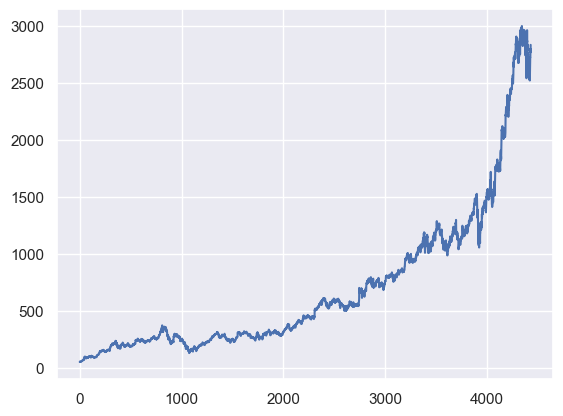

In [6]:
plt.plot(df['close'].values)

### Generate Useful Features

In [7]:
features = gen_features(df)
#only keep window-end samples before full window are invalid
features = features[window:]
features.head()

,target,close,volume,day_HL,sma,ema,rsi,macd_line,macd_signal,macd_histogram,bb_middle,bb_upper,bb_lower
30,2.299374,0.106864,0.433327,1.281803,0.053120,0.061830,1.703372,0.022290,0.017372,0.004918,0.053120,0.119012,-0.012772
31,1.870568,0.113754,0.273592,0.714523,0.058767,0.066775,1.684355,0.023628,0.018623,0.005005,0.058767,0.125140,-0.007605
32,2.450771,0.122781,0.480182,1.558216,0.064577,0.072109,1.704843,0.025127,0.019924,0.005203,0.064577,0.132050,-0.002896
33,-0.932282,0.119347,0.331007,0.636254,0.070085,0.076608,1.634284,0.025741,0.021087,0.004654,0.070085,0.136498,0.003672
34,1.291208,0.124103,0.381418,0.870739,0.075828,0.081131,1.610880,0.026309,0.022132,0.004177,0.075828,0.139911,0.011746


Text(0.5, 1.0, 'Normalized Closing Price Using Accumulated % Changes')

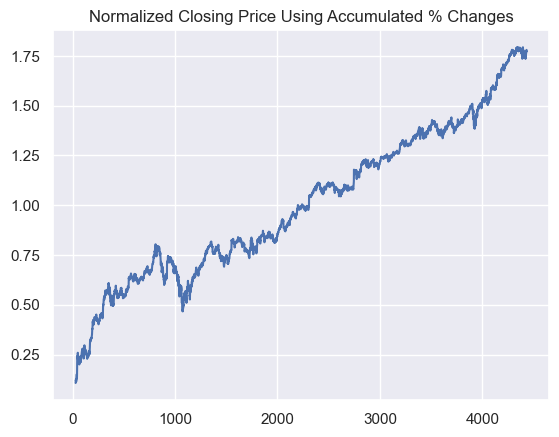

In [8]:
plt.plot(features['close'])
plt.title('Normalized Closing Price Using Accumulated % Changes')

### Generate GRU train and test split

In [9]:
target = 0 #predict closing delta
data = features.to_numpy()
datax, datay = generate_LSTM_data(data, sequence_size=20, target_idx=target)
print('LSTM Data')
print("> Data X: " + str(datax.shape))
print("> Data y: " + str(datay.shape))
test_size = 500
datax_train = datax[:-test_size]
datay_train = datay[:-test_size]
print('Train Set')
print("> Data X: " + str(datax_train.shape))
print("> Data y: " + str(datay_train.shape))
datax_test = datax[-test_size:]
datay_test = datay[-test_size:]
print('Test Set')
print("> Data X: " + str(datax_test.shape))
print("> Data y: " + str(datay_test.shape))

LSTM Data
> Data X: (4380, 20, 13)
> Data y: (4380, 1)
Train Set
> Data X: (3880, 20, 13)
> Data y: (3880, 1)
Test Set
> Data X: (500, 20, 13)
> Data y: (500, 1)


### Define Model

In [11]:
class GRU_Model(tf.keras.Model):
    def __init__(self, num_layers, hidden_dim, output_size, dropout_rate=0.1):
        super(GRU_Model, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.output_size = output_size

        self.gru_layers = [
            tf.keras.layers.GRU(
                hidden_dim,
                activation='tanh',
                return_sequences=True
            ) for _ in range(num_layers-1)
        ]
        self.last_gru = tf.keras.layers.GRU(
            hidden_dim,
            activation='tanh',
            return_sequences=False
        )
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dense1 = tf.keras.layers.Dense(hidden_dim//2)
        self.dense2 = tf.keras.layers.Dense(output_size)
    
    def call(self, x):
        for gru_layer in self.gru_layers:
            x = gru_layer(x)
            x = self.dropout(x)
        x = self.last_gru(x)
        x = self.dropout(x)
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        return x

### Train Model

In [12]:
mymodel = GRU_Model(num_layers=5, hidden_dim=128, output_size=1, dropout_rate=0.1)
mymodel.compile(optimizer="adam", loss="mean_squared_error")
eval = mymodel.evaluate(datax_train, datay_train)

122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.5859


In [13]:
#overfits past 40 epochs for GOOGL dataset
history = mymodel.fit(
    x = datax_train,
    y = datay_train,
    validation_split=0.25,
    epochs=40,
    batch_size=128
)

Epoch 1/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 3.6771 - val_loss: 2.5609
Epoch 2/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 3.6529 - val_loss: 2.5576
Epoch 3/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 3.6551 - val_loss: 2.5578
Epoch 4/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 3.6556 - val_loss: 2.6006
Epoch 5/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 3.6731 - val_loss: 2.5717
Epoch 6/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 3.6611 - val_loss: 2.5499
Epoch 7/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 3.6517 - val_loss: 2.5483
Epoch 8/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 3.6455 - val_loss: 2.5531
Epoch 9/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 3.6556 - val_loss: 2.5550
Epoch 10/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 3.6410 - val_loss: 2.5624
Epoch 11/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 3.6332 - val_loss: 2.5692
Epoch 12/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 3.6

### Plot Performance

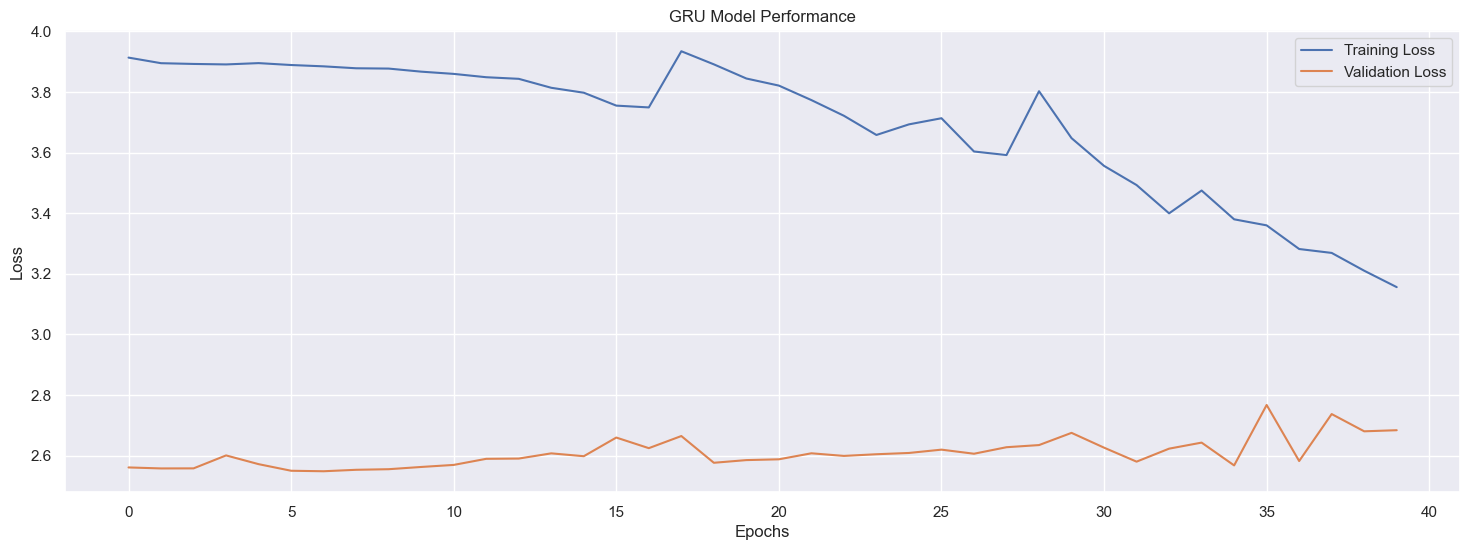

In [14]:
# Visualizing model performance during training
plt.figure(figsize=(18, 6))

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.title("GRU Model Performance")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


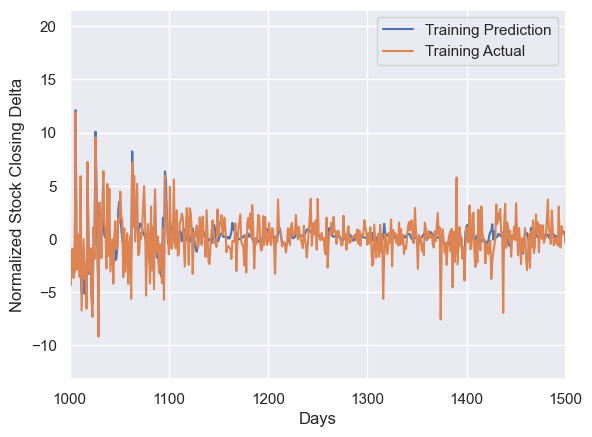

In [15]:
train_predictions = mymodel.predict(datax_train)
train_actual = datay_train
plt.plot(train_predictions, label='Training Prediction')
plt.plot(train_actual, label='Training Actual')
plt.xlabel('Days')
plt.ylabel('Normalized Stock Closing Delta')
plt.xlim([1000, 1500])
plt.legend()

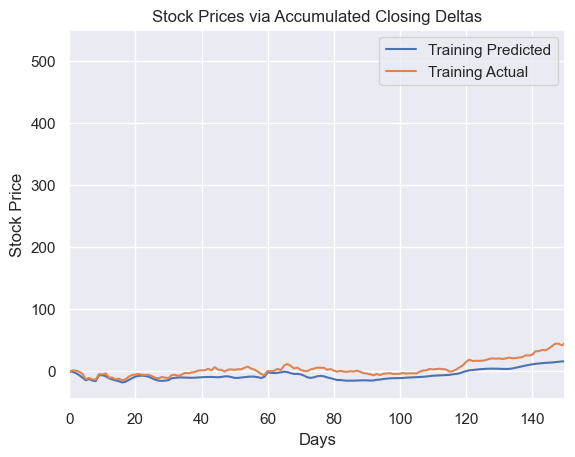

In [17]:
stock_price_train_pred = np.cumsum(train_predictions)
stock_price_train_actual = np.cumsum(train_actual)
plt.plot(stock_price_train_pred, label='Training Predicted')
plt.plot(stock_price_train_actual, label='Training Actual')
plt.title('Stock Prices via Accumulated Closing Deltas')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.xlim([0, 150])
plt.legend()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


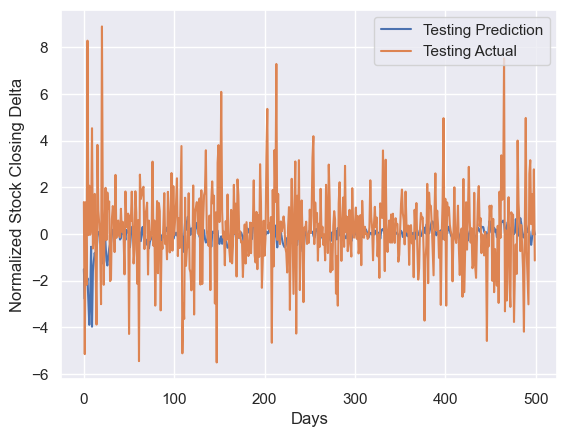

In [18]:
test_predictions = mymodel.predict(datax_test)
test_actual = datay_test
plt.plot(test_predictions, label='Testing Prediction')
plt.plot(test_actual, label='Testing Actual')
plt.xlabel('Days')
plt.ylabel('Normalized Stock Closing Delta')
plt.legend()

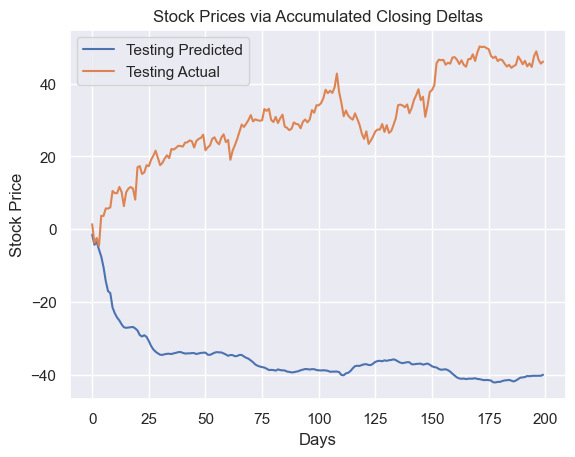

In [19]:
stock_price_test_pred = np.cumsum(test_predictions[0:200])
stock_price_test_actual = np.cumsum(test_actual[0:200])
plt.plot(stock_price_test_pred, label='Testing Predicted')
plt.plot(stock_price_test_actual, label='Testing Actual')
plt.title('Stock Prices via Accumulated Closing Deltas')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()

### Try Predicting Tesla Prices

In [20]:
stock_df = pd.read_csv("../stock_yfinance_data.csv")
ticker = 'TSLA'
stock_filt = stock_df['Stock Name'] == ticker
tsla_df = stock_df[stock_filt]
window = 30
tsla_df = clean_stock_data(tsla_df, window)
features = gen_features(tsla_df)
#only keep window-end samples before full window are invalid
features = features[window:]
features.head()


,target,close,volume,day_HL,sma,ema,rsi,macd_line,macd_signal,macd_histogram,bb_middle,bb_upper,bb_lower
30,-0.415753,1.389737,-0.225144,1.205485,1.225250,1.240823,1.294347,0.337084,0.377391,-0.040307,1.225250,2.329673,0.120826
31,-2.829310,1.274551,-0.123877,0.834094,1.271798,1.244036,1.048356,0.298930,0.361699,-0.062768,1.271798,2.295270,0.248325
32,-1.938224,1.195642,0.185585,1.239311,1.307861,1.239427,1.022191,0.259337,0.341226,-0.081890,1.307861,2.261470,0.354252
33,4.079377,1.361721,-0.103368,1.246601,1.353595,1.251074,1.061015,0.238609,0.320703,-0.082094,1.353595,2.216830,0.490360
34,3.250121,1.494039,0.042524,1.399640,1.405584,1.274213,1.051915,0.230206,0.302603,-0.072398,1.405584,2.159023,0.652145


In [21]:
tsla_data = features.to_numpy()
datax, datay = generate_LSTM_data(tsla_data, sequence_size=20, target_idx=target)
print('TSLA LSTM Data')
print("> Data X: " + str(datax.shape))
print("> Data y: " + str(datay.shape))

TSLA LSTM Data
> Data X: (201, 20, 13)
> Data y: (201, 1)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


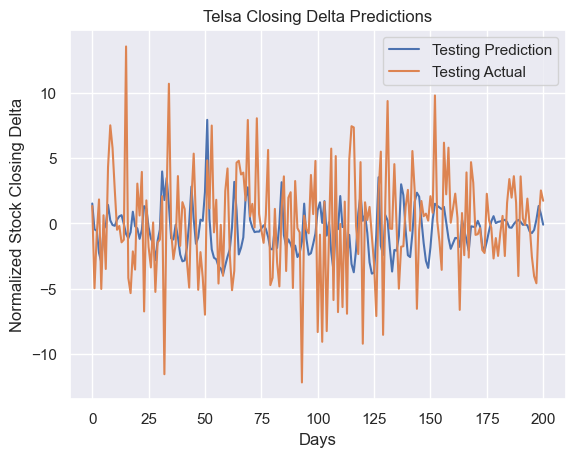

In [22]:
tsla_predictions = mymodel.predict(datax)
tsla_actual = datay
plt.plot(tsla_predictions, label='Testing Prediction')
plt.plot(tsla_actual, label='Testing Actual')
plt.title('Telsa Closing Delta Predictions')
plt.xlabel('Days')
plt.ylabel('Normalized Stock Closing Delta')
plt.legend()

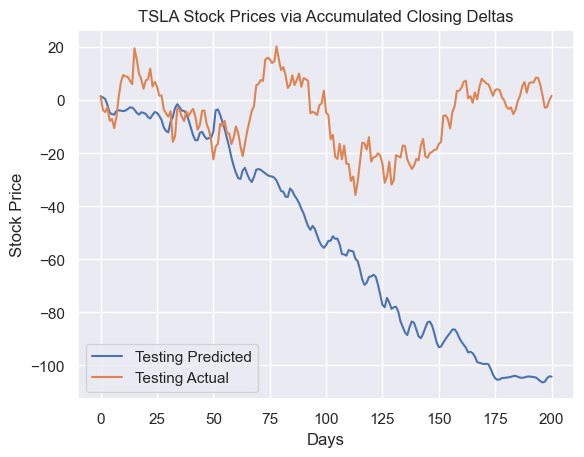

In [23]:
#cumulative 30 days
tsla_price_pred = np.cumsum(tsla_predictions)
tsla_price_actual = np.cumsum(tsla_actual)
plt.plot(tsla_price_pred, label='Testing Predicted')
plt.plot(tsla_price_actual, label='Testing Actual')
plt.title('TSLA Stock Prices via Accumulated Closing Deltas')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()